## CIFAR 10

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

You can get the data via:

    wget http://pjreddie.com/media/files/cifar.tgz

In [2]:
from fastai.conv_learner import *

from pathlib import Path

if os.name == 'nt':
    PATH = str(Path.home()) + "\\data\\cifar10\\"
else:
    PATH = "data/cifar10/"
    
os.makedirs(PATH, exist_ok=True)

In [3]:
def moveFilesToSubDirsFromFileName(path):
    files = os.listdir(path)
    for f in files:
        if os.path.isdir(os.path.join(path, f)):
            continue
        filename, file_extension = os.path.splitext(f)
        regex = re.compile('[^a-zA-Z]')        
        file_label = regex.sub('', filename)
        target_folder = os.path.join(path, file_label)
        if not os.path.exists(target_folder): os.makedirs(target_folder)
        os.rename(os.path.join(path, f), os.path.join(target_folder, f))
    
moveFilesToSubDirsFromFileName(os.path.join(PATH, "train"))
moveFilesToSubDirsFromFileName(os.path.join(PATH, "test"))

In [4]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [5]:
def get_data(sz,bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlipXY()], pad=sz//8)
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [6]:
bs=256

### Look at data

In [7]:
data = get_data(32, 4)

In [8]:
x,y=next(iter(data.trn_dl))

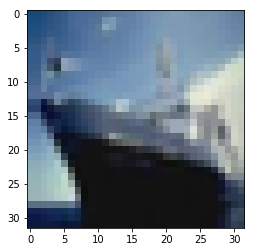

In [9]:
plt.imshow(data.trn_ds.denorm(x)[0]);

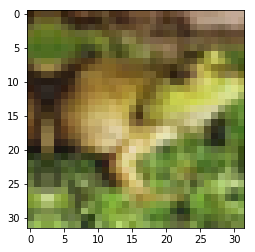

In [10]:
plt.imshow(data.trn_ds.denorm(x)[1]);

## Fully connected model

In [11]:
data = get_data(32,bs)

In [12]:
lr=1e-2

From [this notebook](https://github.com/KeremTurgutlu/deeplearning/blob/master/Exploring%20Optimizers.ipynb) by our student Kerem Turgutlu:

In [13]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

In [14]:
learn = ConvLearner.from_model_data(SimpleNet([32*32*3, 40,10]), data)

In [15]:
learn, [o.numel() for o in learn.model.parameters()]

(SimpleNet(
   (layers): ModuleList(
     (0): Linear(in_features=3072, out_features=40)
     (1): Linear(in_features=40, out_features=10)
   )
 ), [122880, 40, 400, 10])

In [16]:
learn.summary()

OrderedDict([('Linear-1',
              OrderedDict([('input_shape', [-1, 3072]),
                           ('output_shape', [-1, 40]),
                           ('trainable', True),
                           ('nb_params', 122920)])),
             ('Linear-2',
              OrderedDict([('input_shape', [-1, 40]),
                           ('output_shape', [-1, 10]),
                           ('trainable', True),
                           ('nb_params', 410)]))])

In [17]:
%time learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 73%|████████████████████████████████████████████████████▏                  | 144/196 [00:06<00:02, 23.67it/s, loss=14]
Wall time: 6.12 s                                                                                                      


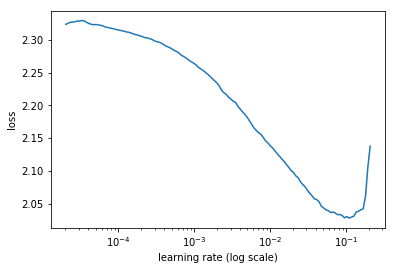

In [18]:
learn.sched.plot()

In [19]:
%time learn.fit(lr, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       1.75672  1.64188  0.42227]                                                                                  
[ 1.       1.67787  1.56315  0.44248]                                                                                  

Wall time: 16.6 s


In [20]:
%time learn.fit(lr, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       1.60952  1.50977  0.46787]                                                                                  
[ 1.       1.59762  1.49019  0.47519]                                                                                  

Wall time: 15.9 s


## CNN

In [21]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, stride=2)
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [22]:
learn = ConvLearner.from_model_data(ConvNet([3, 20, 40, 80], 10), data)

In [23]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 15, 15]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 20, 15, 15]),
                           ('output_shape', [-1, 40, 7, 7]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 40, 7, 7]),
                           ('output_shape', [-1, 80, 3, 3]),
                           ('trainable', True),
                           ('nb_params', 28880)])),
             ('AdaptiveMaxPool2d-4',
              OrderedDict([('input_shape', [-1, 80, 3, 3]),
                           ('output_shape', [-1, 80, 1, 1]),
                           ('nb_params', 0)])),
             ('Linear-5',
              OrderedDict

In [24]:
learn.lr_find(end_lr=100)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 94%|█████████████████████████████████████████████████████████████████▏   | 185/196 [00:06<00:00, 26.56it/s, loss=10.3]


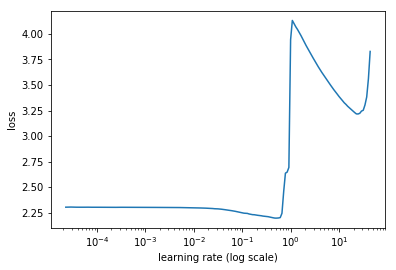

In [25]:
learn.sched.plot()

In [26]:
%time learn.fit(1e-1, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       1.70566  1.55394  0.42607]                                                                                  
[ 1.       1.50617  1.41764  0.48311]                                                                                  

Wall time: 16.3 s


In [27]:
%time learn.fit(1e-1, 4, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

[ 0.       1.31879  1.24001  0.54766]                                                                                  
[ 1.       1.24999  1.17535  0.57754]                                                                                  
[ 2.       1.20963  1.13417  0.58975]                                                                                  
[ 3.       1.18315  1.10682  0.60117]                                                                                  

Wall time: 32.8 s


## Refactored

In [28]:
class ConvLayer(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x): return F.relu(self.conv(x))

In [29]:
class ConvNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([ConvLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [30]:
learn = ConvLearner.from_model_data(ConvNet2([3, 20, 40, 80], 10), data)

In [31]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('ConvLayer-2',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('ConvLayer-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 40, 8, 8]),
                 

In [32]:
%time learn.fit(1e-1, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       1.73004  1.66302  0.39424]                                                                                  
[ 1.       1.51763  1.44444  0.48389]                                                                                  

Wall time: 16.4 s


In [33]:
%time learn.fit(1e-1, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       1.37625  1.2916   0.53633]                                                                                  
[ 1.       1.29541  1.22229  0.56123]                                                                                  

Wall time: 16.2 s


## BatchNorm

In [34]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [35]:
class ConvBnNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [36]:
learn = ConvLearner.from_model_data(ConvBnNet([10, 20, 40, 80, 160], 10), data)

In [37]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 760)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7200)])),
             ('BnLayer-5',
              OrderedDict([

In [38]:
%time learn.fit(3e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       1.49149  1.34251  0.51973]                                                                                  
[ 1.       1.25972  1.18452  0.57754]                                                                                  

Wall time: 18 s


In [39]:
%time learn.fit(1e-1, 4, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

[ 0.       1.19393  1.05145  0.62021]                                                                                  
[ 1.       1.05598  0.94144  0.66611]                                                                                  
[ 2.       0.96158  0.87867  0.68779]                                                                                  
[ 3.       0.90674  0.84145  0.70234]                                                                                  

Wall time: 35.9 s


## Deep BatchNorm

In [40]:
class ConvBnNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([BnLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2 in zip(self.layers, self.layers2):
            x = l(x)
            x = l2(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [41]:
learn = ConvLearner.from_model_data(ConvBnNet2([10, 20, 40, 80, 160], 10), data)

In [42]:
%time learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       1.53271  1.49768  0.46963]                                                                                  
[ 1.       1.30423  1.24167  0.54883]                                                                                  

Wall time: 21.4 s


In [43]:
%time learn.fit(1e-2, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       1.12008  1.04456  0.62627]                                                                                  
[ 1.       1.05357  0.96474  0.65488]                                                                                  

Wall time: 21.4 s


## Resnet

In [44]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [45]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [46]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 10), data)

In [47]:
wd=1e-5

In [48]:
%time learn.fit(1e-2, 2, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       1.59113  1.49453  0.46338]                                                                                  
[ 1.       1.37349  1.22625  0.55342]                                                                                  

Wall time: 25.2 s


In [49]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       1.17066  1.08366  0.61221]                                                                                  
[ 1.       1.13605  1.06043  0.62422]                                                                                  
[ 2.       0.99803  0.97016  0.65547]                                                                                  
[ 3.       1.03604  0.96462  0.6582 ]                                                                                  
[ 4.       0.93639  0.87275  0.68682]                                                                                  
[ 5.       0.84403  0.80942  0.71367]                                                                                  
[ 6.       0.79157  0.82071  0.7081 ]                                                                                  

Wall time: 1min 28s


In [50]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=32), HTML(value='')))

[ 0.       0.88371  0.85828  0.69961]                                                                                  
[ 1.       0.79409  0.7757   0.72891]                                                                                  
[ 2.       0.72686  0.72306  0.75303]                                                                                  
[ 3.       0.68315  0.71784  0.75147]                                                                                  
[ 4.       0.78573  0.7956   0.72285]                                                                                  
[ 5.       0.71409  0.74605  0.74658]                                                                                  
[ 6.       0.62662  0.67092  0.77295]                                                                                  
[ 7.       0.5851   0.67621  0.76738]                                                                                  
[ 8.       0.69434  0.72705  0.75361]   

## Resnet 2

In [51]:
class Resnet2(nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = BnLayer(3, 16, stride=1, kernel_size=7)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return F.log_softmax(self.out(x), dim=-1)

In [52]:
learn = ConvLearner.from_model_data(Resnet2([16, 32, 64, 128, 256], 10, 0.2), data)

In [53]:
wd=1e-6

In [54]:
%time learn.fit(1e-2, 2, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

[ 0.       1.75615  1.65624  0.43496]                                                                                  
[ 1.       1.49073  1.33641  0.51992]                                                                                  

Wall time: 27.2 s


In [55]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       1.26875  1.21842  0.57188]                                                                                  
[ 1.       1.26527  1.2182   0.58945]                                                                                  
[ 2.       1.1036   1.21541  0.61709]                                                                                  
[ 3.       1.17592  1.05245  0.63115]                                                                                  
[ 4.       1.03886  0.97442  0.65596]                                                                                  
[ 5.       0.92901  0.90112  0.68574]                                                                                  
[ 6.       0.88025  0.87652  0.69238]                                                                                  

Wall time: 1min 35s


In [56]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

HBox(children=(IntProgress(value=0, description='Epoch', max=32), HTML(value='')))

[ 0.       1.00094  1.01136  0.66338]                                                                                  
[ 1.       0.89804  0.85928  0.70312]                                                                                  
[ 2.       0.80625  0.81057  0.71514]                                                                                  
[ 3.       0.75848  0.76292  0.73291]                                                                                  
[ 4.       0.87209  0.83129  0.7124 ]                                                                                  
[ 5.       0.78005  0.77524  0.73037]                                                                                  
[ 6.       0.7008   0.69385  0.75566]                                                                                  
[ 7.       0.65048  0.69195  0.75908]                                                                                  
[ 8.       0.76155  0.74107  0.74541]   

In [57]:
learn.save('tmp3')

In [58]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)

In [59]:
metrics.log_loss(y,preds), accuracy(preds,y)

(0.4611881434458599, 0.84470000000000001)

### End